In [1]:
import os
import sys
from nltk.corpus import stopwords
import re
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
from pyspark.sql import SparkSession, SQLContext
import os
import pyspark.sql.functions as f
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("SparkByExamples.com") \
    .getOrCreate()

22/04/13 14:40:47 WARN Utils: Your hostname, DSGPU05 resolves to a loopback address: 127.0.1.1; using 10.10.11.64 instead (on interface eno1)
22/04/13 14:40:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/13 14:40:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sc = SparkSession.builder.appName('App Name').master("local[*]").getOrCreate()
sqlContext = SQLContext(sparkContext=sc.sparkContext, sparkSession=sc)

In [4]:
classics = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("data/fanfics_raw.csv"))

In [5]:
classics.show()

+--------------------+--------------------+--------------------+
|                  id|                text|                type|
+--------------------+--------------------+--------------------+
|             1536152|           Chapter 1|                null|
|Going back was th...| after a case lik...| I’d be moved to ...|
|           Chapter 2|                null|                null|
|It was during my ...| Sophia was no lo...| especially since...|
|           Chapter 3|                null|                null|
|Following Sophia ...| I ducked in an e...| waiting under a ...|
|           Chapter 4|                null|                null|
|Aegis breaking in...| but when they ca...| barely managing ...|
|           Chapter 5|                null|                null|
|I hated coming to...|                sure| but everyone her...|
|           Chapter 6|                null|                null|
|             Somehow| this time was ev...| my instincts wer...|
|           Chapter 7|   

In [6]:
import string

In [7]:
classics_df = classics.withColumn('line', f.explode(f.split(f.col('text'), '\n')))
classics_df.show()

+--------------------+--------------------+--------------------+--------------------+
|                  id|                text|                type|                line|
+--------------------+--------------------+--------------------+--------------------+
|             1536152|           Chapter 1|                null|           Chapter 1|
|Going back was th...| after a case lik...| I’d be moved to ...| after a case lik...|
|It was during my ...| Sophia was no lo...| especially since...| Sophia was no lo...|
|Following Sophia ...| I ducked in an e...| waiting under a ...| I ducked in an e...|
|Aegis breaking in...| but when they ca...| barely managing ...| but when they ca...|
|I hated coming to...|                sure| but everyone her...|                sure|
|             Somehow| this time was ev...| my instincts wer...| this time was ev...|
|The restaurant Li...| just off the Boa...| and without thos...| just off the Boa...|
|I managed to snea...| I tested for spe...| there were

In [8]:
classics = classics_df.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = classics                                                  \
    .map( lambda document: document.strip().lower())               \
    .map( lambda document: re.split(" ", document))          \
    .map( lambda word: [x for x in word if x.isalpha()])           \
    .map( lambda word: [x for x in word if len(x) > 3] )           \
    .map( lambda word: [x for x in word if x not in StopWords])    \
    .zipWithIndex()

In [9]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, IDF
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [10]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [11]:
num_topics = 10
max_iterations = 100
lda = LDA(k=num_topics, maxIter=max_iterations)
lda_model = lda.fit(result_tfidf[['index','features']])

22/04/13 14:41:04 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/13 14:41:04 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [12]:
classics_df.printSchema()
classics_df.show()

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- type: string (nullable = true)
 |-- line: string (nullable = true)

+--------------------+--------------------+--------------------+--------------------+
|                  id|                text|                type|                line|
+--------------------+--------------------+--------------------+--------------------+
|             1536152|           Chapter 1|                null|           Chapter 1|
|Going back was th...| after a case lik...| I’d be moved to ...| after a case lik...|
|It was during my ...| Sophia was no lo...| especially since...| Sophia was no lo...|
|Following Sophia ...| I ducked in an e...| waiting under a ...| I ducked in an e...|
|Aegis breaking in...| but when they ca...| barely managing ...| but when they ca...|
|I hated coming to...|                sure| but everyone her...|                sure|
|             Somehow| this time was ev...| my instincts wer...| this time was

In [13]:
lda_model.describeTopics().show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[33, 50, 15, 104,...|[0.02238452329438...|
|    1|[43, 101, 109, 51...|[0.01815690567300...|
|    2|[3, 27, 39, 14, 3...|[0.04823427258338...|
|    3|[26, 111, 97, 112...|[0.01384956592744...|
|    4|[19, 80, 131, 120...|[0.01941985130453...|
|    5|[17, 16, 75, 157,...|[0.02352860969010...|
|    6|[20, 38, 7, 40, 0...|[0.02203676224511...|
|    7|[24, 37, 29, 53, ...|[0.02878695579978...|
|    8|[0, 10, 56, 22, 7...|[0.03749351923424...|
|    9|[5, 23, 9, 18, 2,...|[0.03234670669561...|
+-----+--------------------+--------------------+



/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


In [14]:
from pyspark.sql.types import *
vocab = cvmodel.vocabulary
vocab_broadcast = sc.sparkContext.broadcast(vocab)

#creating LDA model
ldatopics = lda_model.describeTopics()

def map_termID_to_Word(termIndices):
    words = []
    for termID in termIndices:
        words.append(vocab_broadcast.value[termID])

    return words

udf_map_termID_to_Word = udf(map_termID_to_Word , ArrayType(StringType()))

ldatopics_mapped = ldatopics.withColumn("topic_desc", udf_map_termID_to_Word(ldatopics.termIndices))

In [15]:
ldatopics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[33, 50, 15, 104,...|[0.02238452329438...|[looking, face, l...|
|    1|[43, 101, 109, 51...|[0.01815690567300...|[never, nothing, ...|
|    2|[3, 27, 39, 14, 3...|[0.04823427258338...|[says, good, well...|
|    3|[26, 111, 97, 112...|[0.01384956592744...|[take, best, jane...|
|    4|[19, 80, 131, 120...|[0.01941985130453...|[still, everythin...|
|    5|[17, 16, 75, 157,...|[0.02352860969010...|[rachel, beca, be...|
|    6|[20, 38, 7, 40, 0...|[0.02203676224511...|[elizabeth, thoug...|
|    7|[24, 37, 29, 53, ...|[0.02878695579978...|[susie, noelle, r...|
|    8|[0, 10, 56, 22, 7...|[0.03749351923424...|[said, quinn, ask...|
|    9|[5, 23, 9, 18, 2,...|[0.03234670669561...|[know, make, some...|
+-----+--------------------+--------------------+--------------------+



In [16]:
from pyspark.sql.functions import concat_ws, split
import pyspark.sql.functions as f
lda_topics_mapped = ldatopics_mapped.withColumn("topic_desc", concat_ws(" ", ldatopics_mapped.topic_desc).alias("topic_desc_str"))
lda_topics_mapped = lda_topics_mapped.withColumn("termWeights", concat_ws(" ", ldatopics_mapped.topic_desc).alias("topic_desc_str"))
lda_topics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[33, 50, 15, 104,...|looking face litt...|[looking, face, l...|
|    1|[43, 101, 109, 51...|never nothing mea...|[never, nothing, ...|
|    2|[3, 27, 39, 14, 3...|says good well re...|[says, good, well...|
|    3|[26, 111, 97, 112...|take best jane do...|[take, best, jane...|
|    4|[19, 80, 131, 120...|still everything ...|[still, everythin...|
|    5|[17, 16, 75, 157,...|rachel beca behin...|[rachel, beca, be...|
|    6|[20, 38, 7, 40, 0...|elizabeth though ...|[elizabeth, thoug...|
|    7|[24, 37, 29, 53, ...|susie noelle righ...|[susie, noelle, r...|
|    8|[0, 10, 56, 22, 7...|said quinn asked ...|[said, quinn, ask...|
|    9|[5, 23, 9, 18, 2,...|know make somethi...|[know, make, some...|
+-----+--------------------+--------------------+--------------------+



In [31]:
df = ldatopics_mapped.withColumn("new", f.arrays_zip("topic_desc", "termWeights"))\
       .withColumn("new", f.explode("new")) \
        .select("topic", F.col("new.topic_desc").alias("words"), F.col("new.termWeights").alias("termWeights"))

In [32]:
df.show()

+-----+---------+--------------------+
|topic|    words|         termWeights|
+-----+---------+--------------------+
|    0|  looking| 0.02238452329438448|
|    0|     face|0.015220581222461917|
|    0|   little|0.012852535666176113|
|    0|    small|0.012119618968289947|
|    0|   turned|  0.0109259905527643|
|    0|    woman|0.010874975795158533|
|    0|     hear|0.010799221893140025|
|    0| probably|0.010588478669833533|
|    0|    tried|0.009912138958710594|
|    0|     onto|0.008920028247719631|
|    1|    never|  0.0181569056730082|
|    1|  nothing|0.014596659012839729|
|    1|     mean|0.014207592454483683|
|    1|  already|0.014126317669785133|
|    1|    makes|0.012531550428973033|
|    1|   trying|0.011476993340934816|
|    1|  friends|0.010106096615571854|
|    1|charlotte|0.009520899926550582|
|    1|     idea|0.009379777910615526|
|    1|    shino|0.009298768620849992|
+-----+---------+--------------------+
only showing top 20 rows



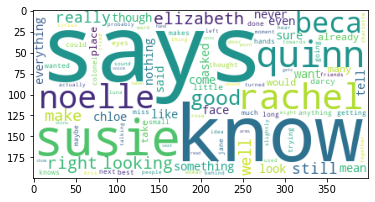

In [34]:
import pyspark.sql.functions as F
from collections import ChainMap
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color="white")

words = dict(ChainMap(*df.select(F.create_map('words', 'termWeights')).rdd.map(lambda x: x[0]).collect()))
# {'scorbutically': 1.76, 'punta': 1.76, 'detail': 1.789, 'lafayette': 1.8, 'maya': 1.854, 'prostate': 1.854, 'quot': 1.856, 'mark': 1.949, 'elite': 1.988, 'trade': 2.012, 'write': 2.083}

plt.imshow(wordcloud.generate_from_frequencies(words))

plt.show()


In [37]:
! cp 'LDA FanFic Algorithm.ipynb' 'LDA Classics Algorithm.ipynb'